# Problem 1

In [1]:
# imports
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import copy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate
from sklearn.model_selection import train_test_split
import pandas as pd

## 1.1 - PCA

Preprocessing script taken from q1-resources/PCA.ipynb

In [2]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [3]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [4]:
dirpath = 'q1-resources/IIIT-CFW/'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


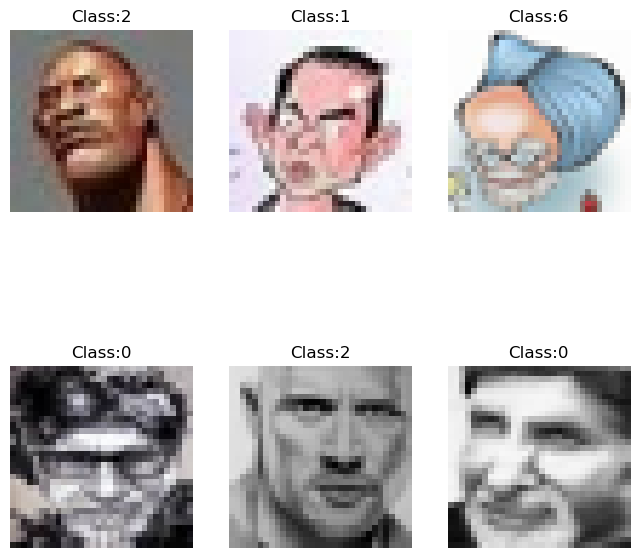

In [5]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

In [6]:
# exploring the given data
X.shape, y.shape

((672, 32, 32, 3), (672,))

We have 672 images of size 32x32 with 3 channels (RGB) in each

### _Perform dimensionality reduction on the IIIT-CFW dataset, varying the number of principle components_

In [7]:
# Flattening images

X_flattened = []

for image in X:
    X_flattened.append(image.ravel())
    
# re-assigning
X = np.array(X_flattened)
X.shape

(672, 3072)

We now have 672 rows of samples x 3072 features per sample

In [8]:
# Function to do PCA on some data
def PCA(given_data, num, glob_cache = None, need_transform = True, return_cache = True):
    data = given_data.copy()
    num_samples, num_features = data.shape

    # getting mean of data = 0
    data = data - np.mean(data, axis = 0)

    # data is assumed to be in samples x features form
    # converting into features x samples (features as rows)
    data = np.transpose(data)

    if glob_cache is None:
        # calculating Cx = (1/(n-1))*X*X^T
        # data_covariance = (data @ data.T)/(num_samples - 1)

        # getting S = X * X^T
        data_covariance = data @ data.T

        # now, we need the eigen values and eigenvectors of X*X^T
        # since, this matrix is symmetric, we can directly get orthonormal eigenvectors using numpy's eigh
        cov_eigenvalues, cov_eigenvectors = np.linalg.eigh(data_covariance)

        # eigh returns eigen values in ascending order -> converting to descending
        cov_eigenvalues = cov_eigenvalues[::-1]
        cov_eigenvectors = cov_eigenvectors[:, ::-1]
        
        glob_cache = [cov_eigenvalues, cov_eigenvectors]
        
    else:
        cov_eigenvalues, cov_eigenvectors = glob_cache
        
    # taking the first num eigenvectors
    filtered_eigenvectors = cov_eigenvectors[:, 0:num] # as eigenvectors[:, i] is the i-th eigenvector 
    
    if need_transform:    
        # NOTE: eigh returns eigenvalues in sorted order directly
        # We, now get transformed data using Y = PX where P = transpose of returned eigenvectors
        data_transformed = filtered_eigenvectors.T @ data

        if return_cache:
            # returning data in samples x features form and variance 
            return data_transformed.T, np.sum(cov_eigenvalues[:num]), glob_cache
        return data_transformed.T, np.sum(cov_eigenvalues[:num]), None
    
    else:
        return None, np.sum(cov_eigenvalues[:num]), glob_cache
    

In [9]:
glob_cache = None

data_transform, cov, glob_cache = PCA(X, 10)
data_transform.shape, cov

((672, 10), 99638.96670104633)

In [11]:
# some more exploring
eigenvalues = glob_cache[0]
for i in range(660, 680):
    print("{}:{} - ".format(i+1, eigenvalues[i]), end = "")
print()

661:0.8175183783897224 - 662:0.7583813461235205 - 663:0.7528785258090179 - 664:0.7248074107940518 - 665:0.6483351878917819 - 666:0.5878020505807761 - 667:0.5806004770136285 - 668:0.5636055395270895 - 669:0.4777923975317037 - 670:0.4456737860840096 - 671:0.4128725292332564 - 672:6.663368362756456e-12 - 673:6.315536793458389e-12 - 674:5.3114262065322525e-12 - 675:4.939662877245754e-12 - 676:3.9940167050678336e-12 - 677:3.727896129062775e-12 - 678:3.2815376371361e-12 - 679:3.219847839405563e-12 - 680:3.030386975383989e-12 - 


**_We see that eigenvalues after the 671st are all 0._**

### Plot the the relationship between the cumulative explained variance and the number of principal components.

In [13]:
max_num = 3072
num_components = np.arange(1, max_num + 1)

combined_variances = []

for i in num_components:
    if i%10 == 0:
        print("-{}-".format(i), end=" ")
    combined_variances.append(PCA(X, i, glob_cache, False)[1])
    
print()

combined_variances = np.array(combined_variances)

-10- -20- -30- -40- -50- -60- -70- -80- -90- -100- -110- -120- -130- -140- -150- -160- -170- -180- -190- -200- -210- -220- -230- -240- -250- -260- -270- -280- -290- -300- -310- -320- -330- -340- -350- -360- -370- -380- -390- -400- -410- -420- -430- -440- -450- -460- -470- -480- -490- -500- -510- -520- -530- -540- -550- -560- -570- -580- -590- -600- -610- -620- -630- -640- -650- -660- -670- -680- -690- -700- -710- -720- -730- -740- -750- -760- -770- -780- -790- -800- -810- -820- -830- -840- -850- -860- -870- -880- -890- -900- -910- -920- -930- -940- -950- -960- -970- -980- -990- -1000- -1010- -1020- -1030- -1040- -1050- -1060- -1070- -1080- -1090- -1100- -1110- -1120- -1130- -1140- -1150- -1160- -1170- -1180- -1190- -1200- -1210- -1220- -1230- -1240- -1250- -1260- -1270- -1280- -1290- -1300- -1310- -1320- -1330- -1340- -1350- -1360- -1370- -1380- -1390- -1400- -1410- -1420- -1430- -1440- -1450- -1460- -1470- -1480- -1490- -1500- -1510- -1520- -1530- -1540- -1550- -1560- -1570- -1580- -1

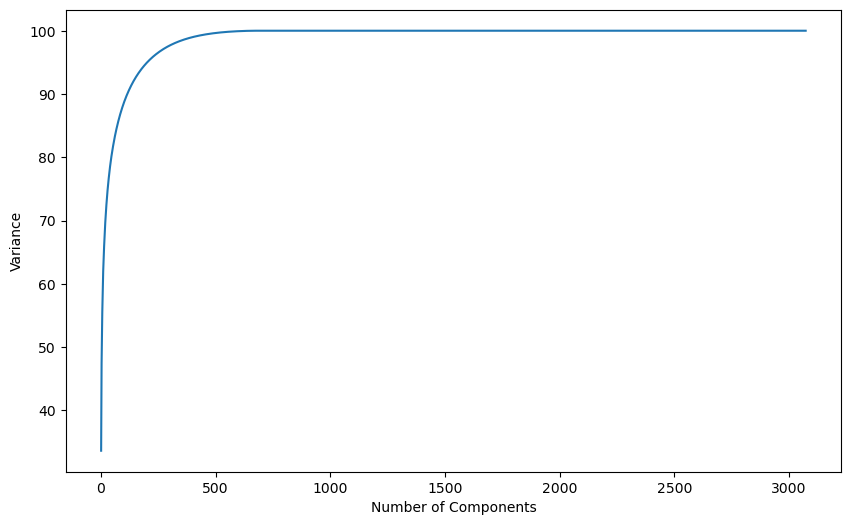

In [14]:
# plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_components, combined_variances/(0.01*combined_variances[-1]))

plt.xlabel('Number of Components')
plt.ylabel('Variance')

plt.show()

**Once again**, as the number of samples are only 672, maximum variance is achieved by 672 principal components.

### Perform the dimensionality reduction on features that you have used for assignment 1 (pictionary dataset)

In [15]:
pictionary_data = np.load('q1-resources/data.npy', allow_pickle=True) # dataset was pickled

In [16]:
# copying KNN implementation from assignment 1

class optKNN:
    '''
        Some variables
    '''
    valid_encodings = (1, 2,)
    valid_distance_metrics = ('euclidean', 'manhattan', 'cosine')
    columns = {
        'game_id': 0,
        'resnet_emb': 1,
        'vit_emb': 2,
        'label': 3,
        'guess_time': 4
    }
    
    
    '''
        Distance Metrics
    '''
    # Euclidean distance metric
    def Euclidean(self, sample):
        return np.sqrt(np.sum((self.train_encodings - sample) ** 2, axis=1)) # neglecting sqrt to make it faster
    
    # Manhattan distance
    def Manhattan(self, sample):
        return np.sqrt(np.sum(np.abs(self.train_encodings - sample), axis=1))
    
    # Cosine distance
    def Cosine(self, sample):
        dot_product = np.dot(sample1, sample2)
        norm_points = np.linalg.norm(self.train_encodings, axis=1)
        norm_point = np.linalg.norm(sample)
        return 1 - dot_product / (norm_points * norm_point)    
    
    '''
        Data Preprocessing Techniques
    '''
    # splits data into train and test
    def split_data(self, split):
        split_index = round((100 - split)/100 * len(self.data_encodings))
        self.train_labels, self.test_labels = self.data_labels[:split_index], self.data_labels[split_index:] 
        self.train_encodings, self.test_encodings = self.data_encodings[:split_index], self.data_encodings[split_index:]

    '''
        Functions that return outputs
    '''        
    # returns nearest neighbour for a given data point
    def predict(self, sample):
        distances_from_all_train_encodings = self.dist_metric(sample)
        
        # Getting 1/(1+weight) of k nearest neighbours
        sorted_indices = np.argsort(distances_from_all_train_encodings)
        nearest_neighbour_distances = distances_from_all_train_encodings[sorted_indices][:self.k]
        weighted_distances = 1 / (1 + nearest_neighbour_distances)

        # Extract k nearest neighbour labels
        nearest_neighbour_labels = self.train_labels[sorted_indices][:self.k]         
        unique_nearest_labels = np.unique(nearest_neighbour_labels)
            
        # adding 1/(1+weight) for all
        nearest_weighted = {}
        for i in unique_nearest_labels:
            nearest_weighted[i] = 0
            
        for i in range(len(nearest_neighbour_distances)):
            nearest_weighted[nearest_neighbour_labels[i]] += 1/(1 + float(nearest_neighbour_distances[i]))
                
        return max(nearest_weighted, key=nearest_weighted.get)
    
    # returns learning metrics
    def run(self):
        # Predict all labels
        predicted_labels = np.array([self.predict(sample) for sample in self.test_encodings])
        
        accuracy = accuracy_score(self.test_labels, predicted_labels)
        precision = precision_score(self.test_labels, predicted_labels, average='micro')
        recall = recall_score(self.test_labels, predicted_labels, average='micro')
        f1 = f1_score(self.test_labels, predicted_labels, average='micro')
        
        return accuracy, precision, recall, f1
            
    
    # init function to create object
    def __init__(self, k = 1, encoding = 1, dist_metric = 'euclidean', split = 20, dataset = pictionary_data, given_data_encodings = None):
        # Checking whether inputs are valid:
        if (k <= 0 or not isinstance(k, int)):
            raise ValueError("k should be a positive natural number")
        if (not encoding in self.valid_encodings):
            raise ValueError("Encoding accepts 1 for resnet and 2 for ViT")
        if (not dist_metric in self.valid_distance_metrics):
            raise ValueError("Distance metric should belong to {}".format(valid_distance_metrics))
        if (split <= 0 or split >= 100):
            raise ValueError("Not a valid split")
            
        distance_metric_functions = {
            'euclidean': self.Euclidean,
            'manhattan': self.Manhattan,
            'cosine': self.Cosine,
        }
        
        # setting varibles
        self.k = k
        self.encoding = encoding
        self.dist_metric = distance_metric_functions[dist_metric]
        self.split = split

        # Extracting features and labels from dataset
        self.data_encodings = dataset[:, encoding]
        self.data_labels = dataset[:, self.columns['label']]
                
        self.data_encodings = np.array([np.squeeze(nested_array) for nested_array in self.data_encodings])
        
        if (given_data_encodings is not None):
            self.data_encodings = given_data_encodings
                        
        # splitting into train and validation
        self.split_data(split)
        

In [17]:
myKNN = optKNN(k = 10, encoding = 2, dist_metric = 'euclidean')

accuracy, precision, recall, f1 = myKNN.run()

print(f'Accuracy: {accuracy:.8f}')
print(f'Precision: {precision:.8f}')
print(f'Recall: {recall:.8f}')
print(f'F1 Score: {f1:.8f}')

Accuracy: 0.31333333
Precision: 0.31333333
Recall: 0.31333333
F1 Score: 0.31333333


In [18]:
vit_data_encodings = pictionary_data[:, 2]
vit_data_encodings = np.array([np.squeeze(nested_array) for nested_array in vit_data_encodings])

In [19]:
vit_data_encodings.shape

(1500, 512)

#### _Dummy run_

In [22]:
glob_cache = None
new_encodings, cov, glob_cache = PCA(vit_data_encodings, 10)
new_encodings.shape, cov

((1500, 10), 14483.082)

In [23]:
myKNN = optKNN(k = 10, encoding = 2, dist_metric = 'euclidean', given_data_encodings=new_encodings)

accuracy, precision, recall, f1 = myKNN.run()

print(f'Accuracy: {accuracy:.8f}')
print(f'Precision: {precision:.8f}')
print(f'Recall: {recall:.8f}')
print(f'F1 Score: {f1:.8f}')

Accuracy: 0.18333333
Precision: 0.18333333
Recall: 0.18333333
F1 Score: 0.18333333


In [25]:
# checking where variance > 0.95
num_components = np.arange(1, vit_data_encodings.shape[1]+1)

combined_variances = []

for i in num_components:
    if (i%10 == 0):
        print("--{}--".format(i), end=" ")
    combined_variances.append(PCA(X, i, glob_cache, False)[1])
    
print()

combined_variances = np.array(combined_variances)

--10-- --20-- --30-- --40-- --50-- --60-- --70-- --80-- --90-- --100-- --110-- --120-- --130-- --140-- --150-- --160-- --170-- --180-- --190-- --200-- --210-- --220-- --230-- --240-- --250-- --260-- --270-- --280-- --290-- --300-- --310-- --320-- --330-- --340-- --350-- --360-- --370-- --380-- --390-- --400-- --410-- --420-- --430-- --440-- --450-- --460-- --470-- --480-- --490-- --500-- --510-- 



	Crosses 95% at 204  components.



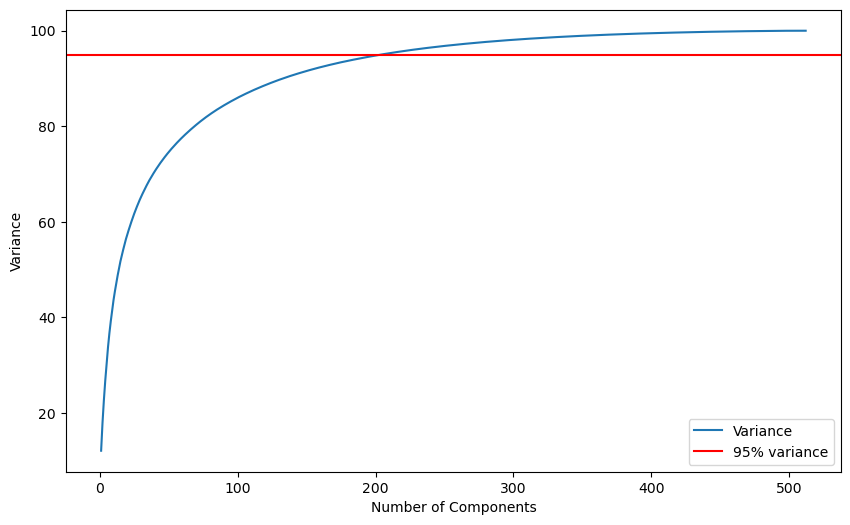

In [32]:
# checking for intersection
min_components = None
for i in range(len(num_components)):
    if (combined_variances[i]/(0.01*combined_variances[-1]) >= 95):
        print("\n\tCrosses 95% at {}  components.\n".format(num_components[i]))
        min_components = num_components[i]
        break

# plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_components, combined_variances/(0.01*combined_variances[-1]), label='Variance')
plt.axhline(y=95, color='r', label='95% variance')

plt.xlabel('Number of Components')
plt.ylabel('Variance')
plt.legend()

plt.show()

In [33]:
all_variants = []
table_headers = ['Accuracy', 'Precision', 'Recall', 'F1', 'Num. Components']

for i in range(1, vit_data_encodings.shape[1]+1):
    if (i%10 == 0):
        print("--{}--".format(i), end = " ")
    new_encodings, cov, glob_cache = PCA(vit_data_encodings, i)
    myKNN = optKNN(k = 10, encoding = 2, dist_metric = 'euclidean', given_data_encodings=new_encodings)

    accuracy, precision, recall, f1 = myKNN.run()

    all_variants.append([accuracy, precision, recall, f1, i])

print()

--10-- --20-- --30-- --40-- --50-- --60-- --70-- --80-- --90-- --100-- --110-- --120-- --130-- --140-- --150-- --160-- --170-- --180-- --190-- --200-- --210-- --220-- --230-- --240-- --250-- --260-- --270-- --280-- --290-- --300-- --310-- --320-- --330-- --340-- --350-- --360-- --370-- --380-- --390-- --400-- --410-- --420-- --430-- --440-- --450-- --460-- --470-- --480-- --490-- --500-- --510-- 


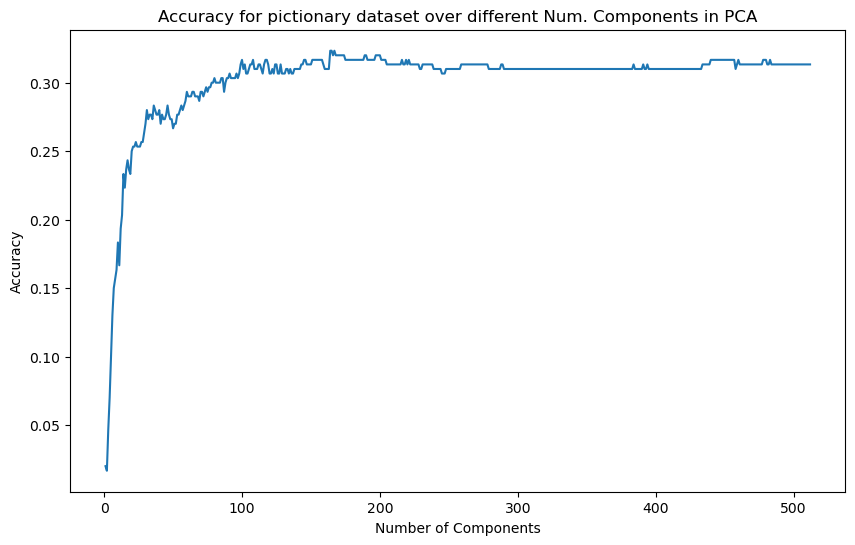

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, vit_data_encodings.shape[1]+1), [row[0] for row in all_variants])

plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title("Accuracy for pictionary dataset over different Num. Components in PCA")

plt.show()

In [35]:
all_variants.sort(reverse = True)
best_variants = all_variants[:min(len(all_variants), 30)]

print(tabulate(best_variants, table_headers, tablefmt="grid"))

+------------+-------------+----------+----------+-------------------+
|   Accuracy |   Precision |   Recall |       F1 |   Num. Components |
+============+=============+==========+==========+===================+
|   0.323333 |    0.323333 | 0.323333 | 0.323333 |               167 |
+------------+-------------+----------+----------+-------------------+
|   0.323333 |    0.323333 | 0.323333 | 0.323333 |               165 |
+------------+-------------+----------+----------+-------------------+
|   0.323333 |    0.323333 | 0.323333 | 0.323333 |               164 |
+------------+-------------+----------+----------+-------------------+
|   0.32     |    0.32     | 0.32     | 0.32     |               200 |
+------------+-------------+----------+----------+-------------------+
|   0.32     |    0.32     | 0.32     | 0.32     |               199 |
+------------+-------------+----------+----------+-------------------+
|   0.32     |    0.32     | 0.32     | 0.32     |               198 |
+-----

**_RESULTS_**

- There is no well known function that can model the change in accuracy over different number of components.
- However, in general, the accuracy tends to increase with the number of components.
    - This can be attributed to the fact that the principal components add more and more significant data to the reduced features.
- Moreover, the maximum accuracy is found _NOT_ at larger component numbers but around the 180s.
    - This can be explained by the fact that a small number of features was sufficient to model the actual data represented by the encoding - other principal components might be modelling noise (which can be explained by the fact that 95% variance is also achieved close to the 180s)

### Observe the impact of dimensionality reduction on the dataset. Use a classifier on the dataset pre and post-dimensionality reduction

In [36]:
# dummy run
glob_cache = None

data_transform, cov, glob_cache = PCA(X, 10)
data_transform.shape, cov

((672, 10), 99638.96670104633)

In [39]:
def logistic_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = KNeighborsClassifier(n_neighbors=5)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [40]:
logistic_model(X, y), logistic_model(data_transform, y)

(0.34074074074074073, 0.4074074074074074)

In [47]:
max_components = 672
num_components = list(range(1, 50))
num_components.extend(list(range(50, 665, 5)))
num_components.extend(list(range(665, max_components+1)))
num_components = np.array(num_components)

accuracies = []
for i in num_components:
    if (i%10 == 0):
        print("--{}--".format(i), end=" ")
    
    data_transform, cov, _ = PCA(X, i, glob_cache, return_cache=False)
    
    accuracies.append(logistic_model(data_transform, y))
    
accuracies = np.array(accuracies)

--10-- --20-- --30-- --40-- --50-- --60-- --70-- --80-- --90-- --100-- --110-- --120-- --130-- --140-- --150-- --160-- --170-- --180-- --190-- --200-- --210-- --220-- --230-- --240-- --250-- --260-- --270-- --280-- --290-- --300-- --310-- --320-- --330-- --340-- --350-- --360-- --370-- --380-- --390-- --400-- --410-- --420-- --430-- --440-- --450-- --460-- --470-- --480-- --490-- --500-- --510-- --520-- --530-- --540-- --550-- --560-- --570-- --580-- --590-- --600-- --610-- --620-- --630-- --640-- --650-- --660-- --670-- 

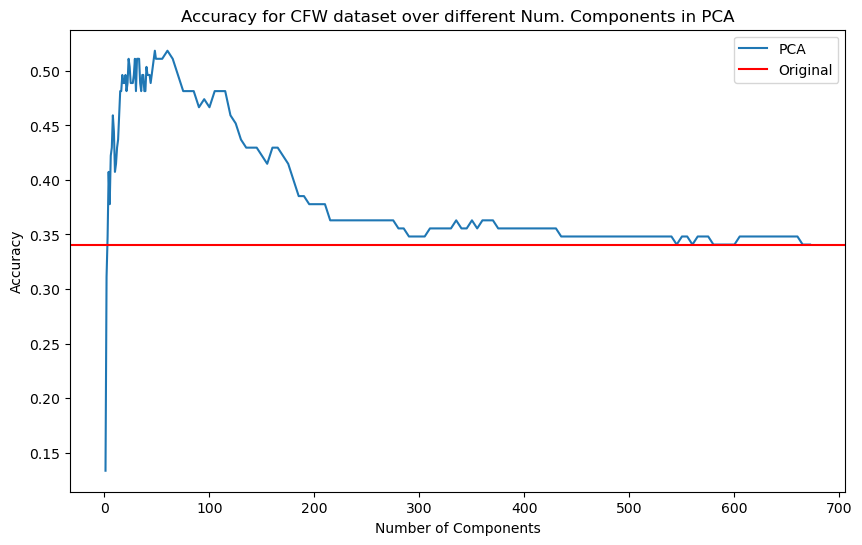

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(num_components, accuracies, label = "PCA")
plt.axhline(y=logistic_model(X, y), color='r', label='Original')


plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title("Accuracy for CFW dataset over different Num. Components in PCA")

plt.legend()
plt.show()

### Some explanation:

- The initial high values can be attributed to a lot of noise in the data
- The features used until 80 numbers are very significant, while the rest of the features don't matter.

## 1.2 Pictionary Dataset

In [49]:
drawer_data = pd.read_csv('q1-resources/pictionary/drawer_attributes.csv')
drawer_data

,d_drawer,d_area_median,d_stroke_freq_median,d_rangestroketime_median,d_firststroketime_median,d_laststroketime_median,d_pcgamestup,d_pcgamestdown,d_pcgameserasehighlight
0,10,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000000,0.000000
1,36,82306.749763,0.578802,21.660,3.512,26.815,0.000000,0.000000,0.777778
2,14,60929.328432,0.239168,25.087,1.368,26.455,1.000000,1.000000,1.000000
3,26,119037.637976,0.402533,54.162,2.459,56.621,0.750000,0.500000,1.000000
4,40,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
95,489,70962.506524,0.545814,27.828,4.873,34.187,0.200000,0.000000,0.400000
96,476,44293.554261,0.214476,24.361,2.619,26.980,0.250000,0.000000,0.500000
97,491,28575.130088,0.281468,31.310,3.671,37.586,0.153846,0.076923,0.461538
98,504,49562.212555,0.172661,40.626,10.302,47.306,0.400000,0.200000,0.400000


In [50]:
guess_data = pd.read_csv('q1-resources/pictionary/guesser_attributes.csv')
guess_data

,g_guesser,g_noofmessage_median,g_firstmessagetime_median,g_lastmessagetime_median,g_rangemessagetime_median,g_pcgamesconfusion,g_entropy
0,10,0.0,0.000000,0.000000,0.000000,0.0,0.000000
1,36,1.0,25.367172,39.041594,0.000000,0.0,0.000000
2,14,2.0,12.988740,51.351317,38.362577,1.0,0.693147
3,26,3.5,20.622346,64.718058,44.095712,0.0,1.242453
4,40,3.0,30.339558,78.943003,48.603445,0.0,1.098612
...,...,...,...,...,...,...,...
95,489,3.0,10.652321,36.320770,10.546721,0.0,1.098612
96,476,1.5,10.728426,37.334943,26.606517,0.0,0.346574
97,491,2.0,31.399657,45.160252,9.038865,0.0,0.693147
98,504,1.5,24.975650,48.008175,21.551010,0.0,0.346574


### Plot the above features with respect to the obtained PCA axes

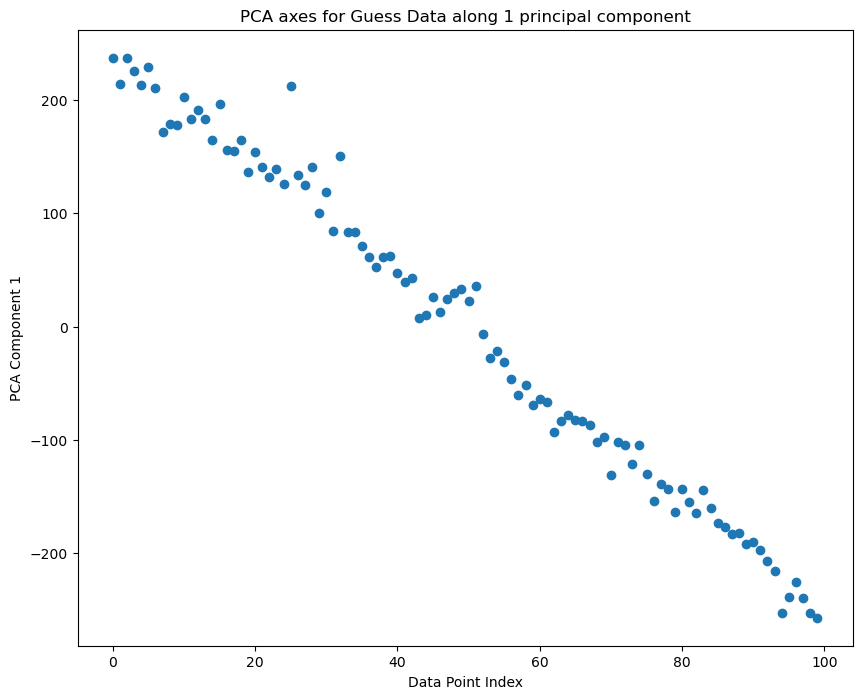

In [76]:
guess_data_pca, cov, _ = PCA(guess_data, 1, None, return_cache=False)
guess_data_pca = guess_data_pca.to_numpy()
plt.figure(figsize=(10, 8))
plt.scatter(range(len(guess_data_pca)), guess_data_pca)
plt.title('PCA axes for Guess Data along 1 principal component')
plt.xlabel('Data Point Index')
plt.ylabel('PCA Component 1')
plt.show()

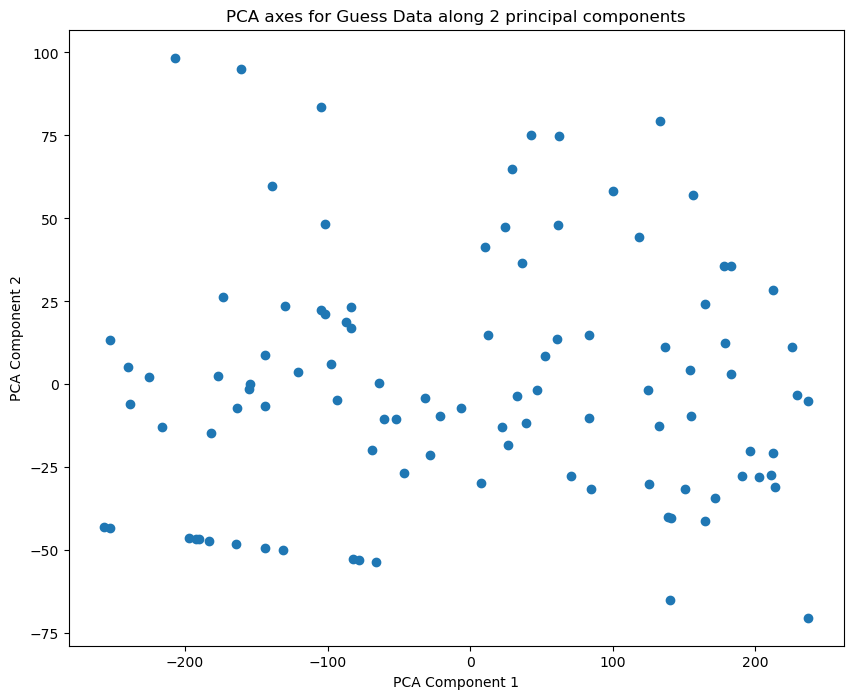

In [86]:
from mpl_toolkits.mplot3d import Axes3D
guess_data_pca, cov, _ = PCA(guess_data, 3, None, return_cache=False)
guess_data_pca = guess_data_pca.to_numpy()
plt.figure(figsize=(10, 8))
plt.scatter(guess_data_pca[:, 0], guess_data_pca[:, 1])
plt.title('PCA axes for Guess Data along 2 principal components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

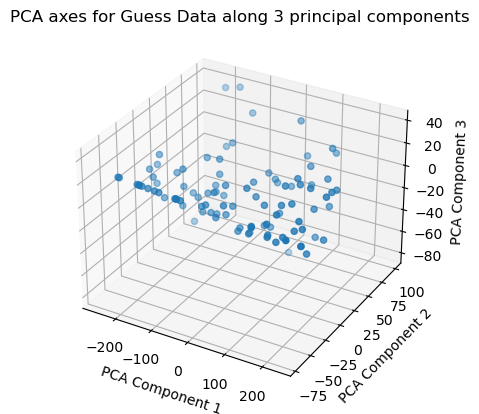

In [87]:
guess_data_pca, cov, _ = PCA(guess_data, 3, None, return_cache=False)
guess_data_pca = guess_data_pca.to_numpy()

ax = plt.figure().add_subplot(projection='3d')

ax.scatter(guess_data_pca[:, 0], guess_data_pca[:, 1], guess_data_pca[:, 2])
plt.title('PCA axes for Guess Data along 3 principal components')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.show()

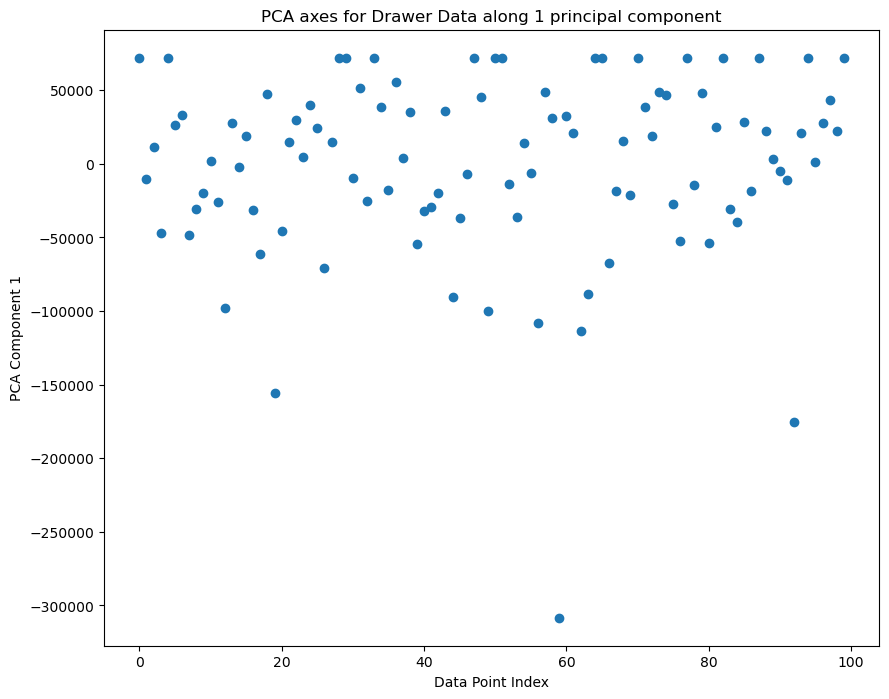

In [88]:
drawer_data_pca, cov, _ = PCA(drawer_data, 1, None, return_cache=False)
drawer_data_pca = drawer_data_pca.to_numpy()
plt.figure(figsize=(10, 8))
plt.scatter(range(len(drawer_data_pca)), drawer_data_pca)
plt.title('PCA axes for Drawer Data along 1 principal component')
plt.xlabel('Data Point Index')
plt.ylabel('PCA Component 1')
plt.show()

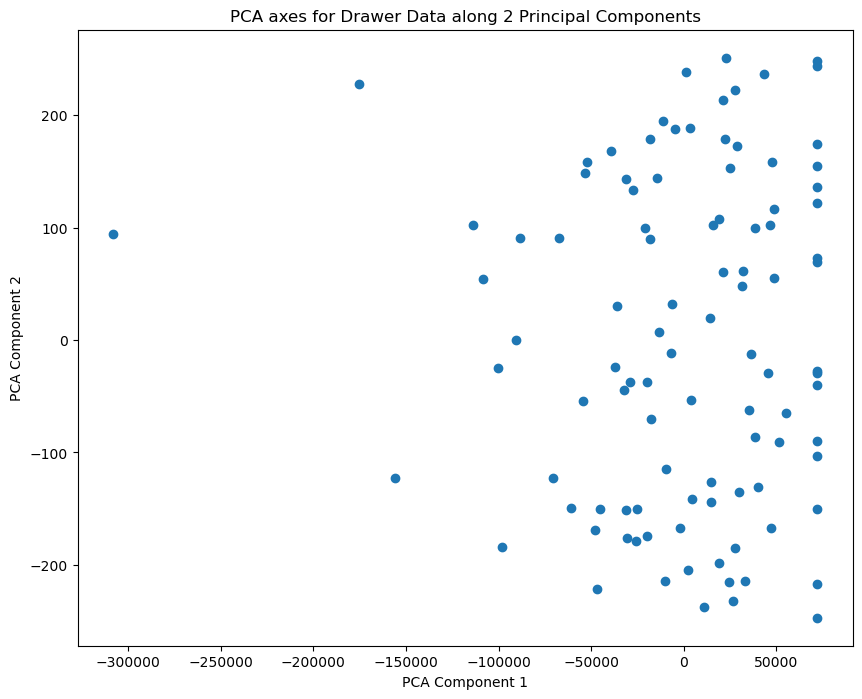

In [90]:
drawer_data_pca, cov, _ = PCA(drawer_data, 2, None, return_cache=False)
drawer_data_pca = drawer_data_pca.to_numpy()
plt.figure(figsize=(10, 8))
plt.scatter(drawer_data_pca[:, 0], drawer_data_pca[:, 1])
plt.title('PCA axes for Drawer Data along 2 Principal Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

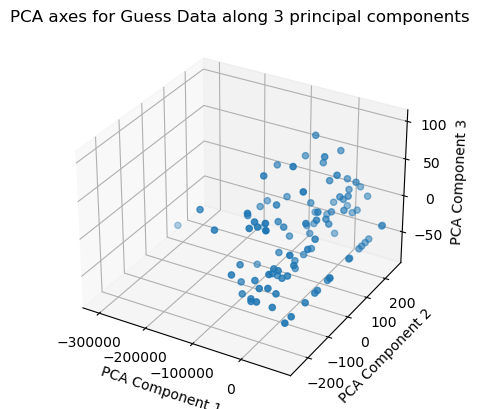

In [91]:
drawer_data_pca, cov, _ = PCA(drawer_data, 3, None, return_cache=False)
drawer_data_pca = drawer_data_pca.to_numpy()

ax = plt.figure().add_subplot(projection='3d')

ax.scatter(drawer_data_pca[:, 0], drawer_data_pca[:, 1], drawer_data_pca[:, 2])
plt.title('PCA axes for Guess Data along 3 principal components')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.show()

### What does each of the new axes that are obtained from PCA represent ?

- The first principal component (PC1) represents the direction in the data along which the variance is maximized. It captures the most significant pattern or variation in the data. In many cases, PC1 corresponds to the dominant trend or the most important feature in the dataset.
    - This is shown by the fact that the the data has the maximum range along the PC1 axes (max_value - min_value_, followed by PC2 and then PC3
- The second principal component (PC2) represents the second most significant pattern in the data, orthogonal (perpendicular) to PC1. It captures the remaining variation that is uncorrelated with PC1. PC2 is the next most important feature or pattern after PC1.
- The third principal component captures even lesser variance.